In [34]:
# packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/curtailment_target_features.csv', sep = ';', index_col=0)

Imputing missing values

In [13]:
# Loop through DataFrame rows
for index, row in df.iterrows():
    # Check if column 'forecast_solar_MW' is NaN
    if pd.isna(row['forecast_solar_MW']):
        # If 'forecast_solar_MW' is NaN, fill it with the value from 'actual_solar_MW'
        df.at[index, 'forecast_solar_MW'] = row['actual_solar_MW']

    if pd.isna(row['actual_solar_MW']):
      df.at[index, 'actual_solar_MW'] = row['forecast_solar_MW']


columns_to_interpolate = ["wind_speed_m/s",  "wind_direction_degrees", "humidity_percent", "radiation_global_J/m2", "air_temperature_K", "wind_gust_max_m/s", "wind_direction_gust_max_degrees", "forecast_solar_MW", "actual_solar_MW", "total_grid_load_MWh", "residual_load_MWh", "pumped_storage_MWh"]

# Assuming df is your DataFrame with missing values
df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear', limit_direction='both')

Dropping level column

In [15]:
df.drop('level', inplace=True, axis=1)

Checking if the data is timeseries dependent or not

In [16]:
df.index = pd.to_datetime(df.index)

Daily mean median and variance of redispatch

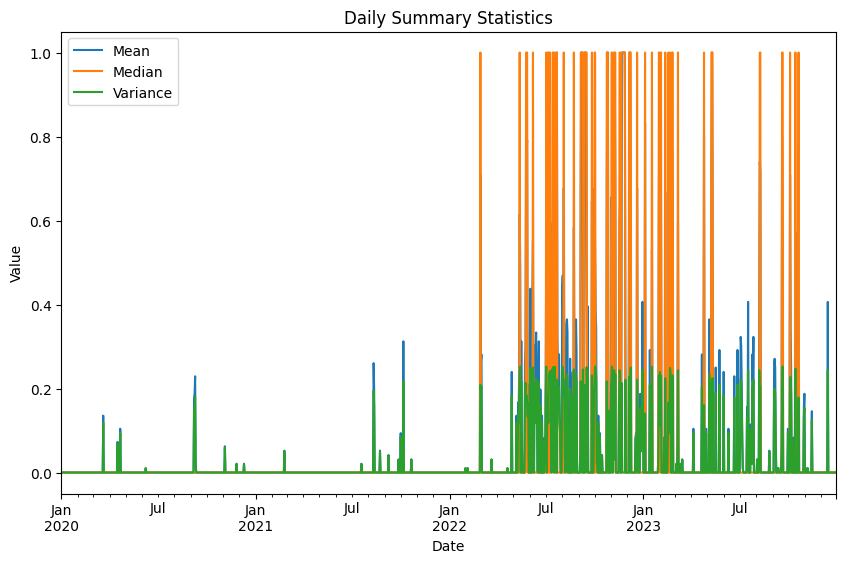

Autocorrelation: 0.960101247666363


In [18]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
daily_summary = df['redispatch'].resample('D').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
daily_summary.plot(title='Daily Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Weekly mean median and variance of redispatch

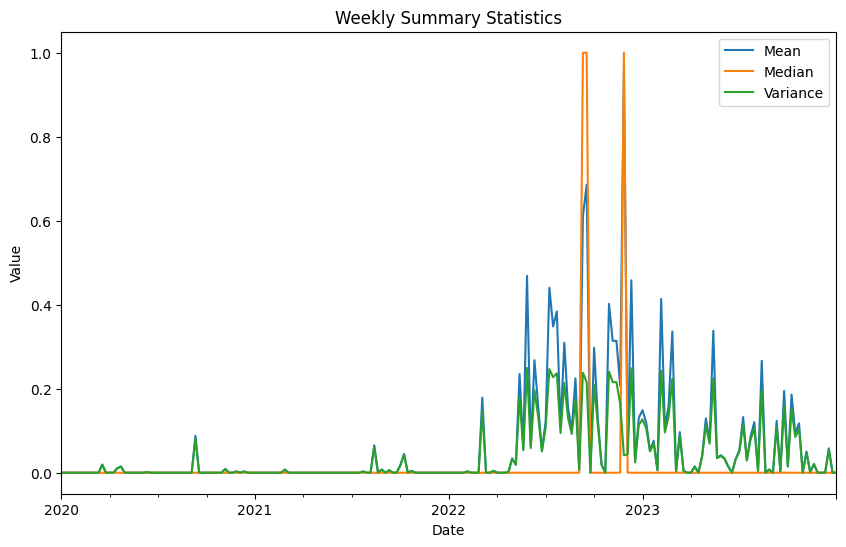

Autocorrelation: 0.960101247666363


In [19]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
weekly_summary = df['redispatch'].resample('W').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
weekly_summary.plot(title='Weekly Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Monthly mean median and variance of redispatch

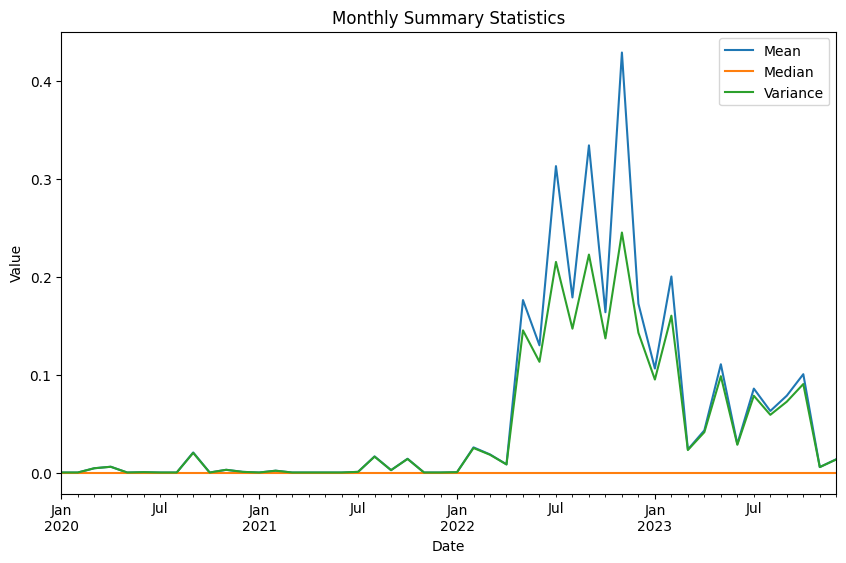

Autocorrelation: 0.960101247666363


In [20]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
monthly_summary = df['redispatch'].resample('M').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
monthly_summary.plot(title='Monthly Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Checking for auto correlation of redispatch

<Figure size 1000x600 with 0 Axes>

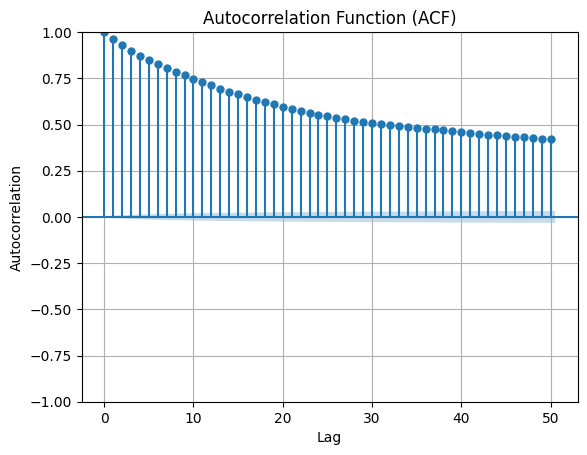

Autocorrelation: 0.960101247666363


In [22]:
# Calculate autocorrelation function (ACF)
acf = pd.Series(data=df['redispatch']).autocorr()

# Plot autocorrelation function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(df['redispatch'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("Autocorrelation:", acf)

Lagging features

In [24]:
df_lagged = pd.DataFrame(index=df.index)

for feature in df.columns: # dependent variable included!
    df_lagged[feature] = df[feature]
    df_lagged[feature + '_lag1'] = df[feature].shift(1)
    df_lagged[feature + '_lag2'] = df[feature].shift(2)
    df_lagged[feature + '_lag3'] = df[feature].shift(3)

df_lagged.dropna(inplace = True) # maybe better ways
df_lagged.drop(['redispatch_lag1', 'redispatch_lag2', 'redispatch_lag3'], axis=1, inplace = True)


In [26]:
df_lagged.head()

,redispatch,wind_speed_m/s,wind_speed_m/s_lag1,wind_speed_m/s_lag2,wind_speed_m/s_lag3,wind_direction_degrees,wind_direction_degrees_lag1,wind_direction_degrees_lag2,wind_direction_degrees_lag3,radiation_global_J/m2,...,total_grid_load_MWh_lag2,total_grid_load_MWh_lag3,residual_load_MWh,residual_load_MWh_lag1,residual_load_MWh_lag2,residual_load_MWh_lag3,pumped_storage_MWh,pumped_storage_MWh_lag1,pumped_storage_MWh_lag2,pumped_storage_MWh_lag3
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:45:00,0.0,2.7,2.4,2.7,2.1,250.0,240.0,265.0,250.0,0.0,...,727.23,730.95,604.33,611.37,620.78,624.18,8.32,6.40,4.35,3.25
2020-01-01 01:00:00,0.0,2.7,2.7,2.4,2.7,260.0,250.0,240.0,265.0,0.0,...,722.20,727.23,600.83,604.33,611.37,620.78,6.32,8.32,6.40,4.35
2020-01-01 01:15:00,0.0,2.9,2.7,2.7,2.4,260.0,260.0,250.0,240.0,0.0,...,719.22,722.20,598.70,600.83,604.33,611.37,8.55,6.32,8.32,6.40
2020-01-01 01:30:00,0.0,3.2,2.9,2.7,2.7,250.0,260.0,260.0,250.0,0.0,...,717.07,719.22,590.62,598.70,600.83,604.33,9.12,8.55,6.32,8.32
2020-01-01 01:45:00,0.0,3.4,3.2,2.9,2.7,255.0,250.0,260.0,260.0,0.0,...,713.63,717.07,582.72,590.62,598.70,600.83,14.73,9.12,8.55,6.32


Trying a convolutional neural network for classification

In [28]:
# Determine the cutoff point for splitting the data into train and test sets based on time
cutoff_time = '2023-07-01'  # Define your cutoff time

# Split the data into train and test sets based on time
train = df[df.index < cutoff_time]
test = df[df.index >= cutoff_time]

# Prepare the data
X_train = train.drop(columns=['redispatch'])  # Extract features
y_train = train['redispatch']  # Extract target

X_test = test.drop(columns=['redispatch'])  # Extract features
y_test = test['redispatch']  # Extract target

In [29]:
# Normalize or scale the features if necessary
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance the classes in the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [32]:
# Reshape the input data to have a 3D shape
X_train_balanced_reshaped = np.expand_dims(X_train_balanced, axis=-1)
X_test_scaled_reshaped = np.expand_dims(X_test_scaled, axis=-1)

# Define model architecture
def make_model(input_shape, num_classes):
    input_layer = Input(input_shape)

    conv1 = Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    output_layer = Dense(num_classes, activation="softmax")(gap)

    return Model(inputs=input_layer, outputs=output_layer)

# Model parameters
input_shape = X_train_balanced_reshaped.shape[1:]
num_classes = len(np.unique(y_train_balanced))

# Create model instance
model = make_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

# Train the model
history = model.fit(
    X_train_balanced_reshaped, y_train_balanced,
    validation_data=(X_test_scaled_reshaped, y_test),
    epochs=500,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
7204/7204 [==============================] - 51s 6ms/step - loss: 0.4812 - accuracy: 0.7662 - val_loss: 0.8764 - val_accuracy: 0.5461 - lr: 0.0010
Epoch 2/500
7204/7204 [==============================] - 47s 6ms/step - loss: 0.3902 - accuracy: 0.8261 - val_loss: 1.0892 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 3/500
7204/7204 [==============================] - 45s 6ms/step - loss: 0.3415 - accuracy: 0.8546 - val_loss: 0.6017 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 4/500
7204/7204 [==============================] - 46s 6ms/step - loss: 0.3087 - accuracy: 0.8723 - val_loss: 0.4867 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 5/500
7204/7204 [==============================] - 45s 6ms/step - loss: 0.2837 - accuracy: 0.8842 - val_loss: 0.6918 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 6/500
7204/7204 [==============================] - 46s 6ms/step - loss: 0.2656 - accuracy: 0.8931 - val_loss: 0.6060 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 7/500
7204/7204 [=======================

550/550 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92     16557
         1.0       0.13      0.27      0.18      1023

    accuracy                           0.85     17580
   macro avg       0.54      0.58      0.55     17580
weighted avg       0.90      0.85      0.88     17580

Confusion Matrix:
[[14734  1823]
 [  742   281]]


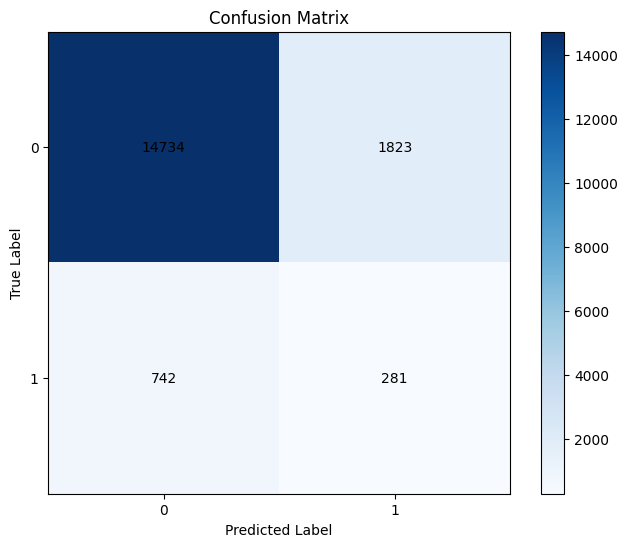

In [35]:
# Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

print("Confusion Matrix:")
conf_mat = confusion_matrix(y_test, y_pred_classes)
print(conf_mat)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(num_classes))
plt.yticks(ticks=np.arange(num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center')
plt.show()

In [ ]:
features_to_keep = ['redispatch', 'wind_speed_m/s', 'radiation_global_J/m2',
                    'air_temperature_K', 'humidity_percent',
                    'wind_gust_max_m/s', 'forecast_solar_MW',
                    'total_grid_load_MWh', 'pumped_storage_MWh']

df = df[features_to_keep]

In [ ]:
# Split the entire dataset into training and test sets
cutoff_time = "2023-01-01"
train = df[df.index < cutoff_time]
test = df[df.index >= cutoff_time]
X_train = train.drop('redispatch', axis = 1)
y_train = train['redispatch']
X_test = test.drop('redispatch', axis = 1)
y_test = test['redispatch']

In [ ]:
# preprocessing pipelines
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_preprocessed, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# define number of epochs and learning rate decay
N_TRAIN = len(X_train_preprocessed)
EPOCHS = 10
BATCH_SIZE = 20
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH,
    decay_rate=1,
    staircase=False)

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')

# define model
def dl_bin_class_model():
    model = tf.keras.Sequential([
        Dense(64, activation='relu', input_dim=8),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])
    return model

# train model
model = dl_bin_class_model()
with tf.device('/device:GPU:0'):
  history = model.fit(X_train_preprocessed,
                    y_train_preprocessed,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1)

Epoch 1/10


TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [ ]:
y_pred = model.predict(X_test_preprocessed)

threshold = 0.3 # counteract class imbalaance?!
y_pred_binary = (y_pred >= threshold).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_binary))

1093/1093 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.60      0.73     32472
         1.0       0.08      0.46      0.14      2484

    accuracy                           0.59     34956
   macro avg       0.51      0.53      0.43     34956
weighted avg       0.87      0.59      0.69     34956



KeyError: 'val_recall'

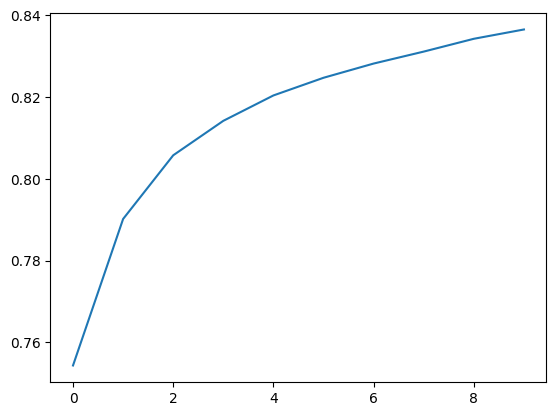

In [ ]:
# plot recall
plt.plot(history.history['recall'], label='train_recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Training and Validation Recall')

# plot loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')




In [ ]:
# is it overfitting?
# Batchnormalization: method to make artificial NNs faster and more stable through re-centering and re-scaling layers inputs
# Dropout: regularisation technique for reducing overfitting in ANNs by preventing complex co-adaptations on training data. Performing model averaging


In [ ]:
'''
## safe
!mkdir -p saved_model
large_model.save('saved_model/my_large_model')

!zip -r saved_model.zip saved_model

# push to GitHub see [3]

## load
# unzip files
import zipfile
with zipfile.ZipFile(‘./saved_model.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Load the saved model
with tf.device('/device:GPU:0'):
    new_large_model = tf.keras.models.load_model('saved_model/my_large_model')

# Check its architecture
new_large_model.summary()'''

"\n## safe \n!mkdir -p saved_model\nlarge_model.save('saved_model/my_large_model')\n\n!zip -r saved_model.zip saved_model\n\n# push to GitHub see [3]\n\n## load\n# unzip files \nimport zipfile\nwith zipfile.ZipFile(‘./saved_model.zip', 'r') as zip_ref:\n    zip_ref.extractall('./')\n\n# Load the saved model\nwith tf.device('/device:GPU:0'):\n    new_large_model = tf.keras.models.load_model('saved_model/my_large_model')\n\n# Check its architecture\nnew_large_model.summary()"